# MNIST
Learn computer vision fundamentals with the famous MNIST data

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, crosstab
from datetime import datetime, timedelta 
from collections import Counter
import tensorflow as tf

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

<br>
### Load data

In [2]:
train = pd.read_csv('data/train.csv')
test= pd.read_csv("data/test.csv")

In [3]:
print('training-set shape: ({0[0]},{0[1]})'.format(train.shape))
train.head(3)

training-set shape: (42000,785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print('testing-set shape: ({0[0]},{0[1]})'.format(test.shape))
test.head(3)

testing-set shape: (28000,784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
labels = train['label']
train = train.drop("label",axis=1)

labels_count = np.unique(labels.values)
labels_count

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

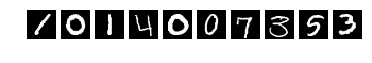

label: [1 0 1 4 0 0 7 3 5 3]


In [6]:
def display(img):
    
    image_size = img.shape[0]
    image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)
    
    # (784) => (28,28)
    one_image = img.reshape(image_width,image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap='Greys_r')

for i in range(10):
    plt.subplot(1,10,i+1)
    display(train.values[i])
plt.show()
print('label: %s' % (labels.values[0:10],))

In [7]:
# convert class labels from scalars to one-hot vectors
# 0 => [1 0 0 0 0 0 0 0 0 0]
# 1 => [0 1 0 0 0 0 0 0 0 0]
# ...
# 9 => [0 0 0 0 0 0 0 0 0 1]
def dense_to_one_hot(target, num_classes):
    one_hot_targets = np.eye(num_classes)[target]
    return one_hot_targets

labels = dense_to_one_hot(labels.values, len(labels_count))

<br>
### Logistic regression as baseline

In [15]:
# Parameters
learning_rate = 0.01
training_epochs = 30
batch_size = 128
display_step = 1

In [9]:
# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes

# Set model weights
W = tf.Variable(tf.zeros([784, 10]))    # tf.random_normal()
#W = tf.random_normal([784, 10])/1000    # tf.random_normal()
b = tf.Variable(tf.zeros([10]))

# Construct model
pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax

# Minimize error using cross entropy
cost = tf.losses.sigmoid_cross_entropy(y, pred)
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

INFO:tensorflow:logits.dtype=<dtype: 'float32'>.
INFO:tensorflow:multi_class_labels.dtype=<dtype: 'float32'>.
INFO:tensorflow:losses.dtype=<dtype: 'float32'>.


In [10]:
def get_batch(data, label, batch_size=64):
    l = len(data)
    arr = np.arange(l)
    np.random.shuffle(arr)
    for ndx in range(0, l, batch_size):
        select = arr[ndx:min(ndx + batch_size, l)]
        yield (data[select], label[select])

In [16]:
# Start training
with tf.Session() as sess:
    sess.run(init)

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = counter = 0.
        
        batch_data = get_batch(train.values, labels, batch_size)
        #train_Y_batch = get_batch(labels, batch_size)
        for data in batch_data:
            batch_xs, batch_ys = data
            # Fit training using batch data
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs, y: batch_ys})

            # Compute average loss
            avg_cost += c
            counter += 1
        avg_cost /= counter
        
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")

    # Test model
    correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    # Calculate accuracy for 3000 examples
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy:", accuracy.eval({x: train.values, y: labels}))
    
    # Prediction
    classification = sess.run(pred, feed_dict={x: test.values})
    result = np.argmax(classification, 1)


Epoch: 0001 cost= 0.670417235
Epoch: 0002 cost= 0.664763266
Epoch: 0003 cost= 0.664000176
Epoch: 0004 cost= 0.663578253
Epoch: 0005 cost= 0.663211472
Epoch: 0006 cost= 0.662912689
Epoch: 0007 cost= 0.662738171
Epoch: 0008 cost= 0.662596620
Epoch: 0009 cost= 0.662442700
Epoch: 0010 cost= 0.662242902
Epoch: 0011 cost= 0.662176647
Epoch: 0012 cost= 0.662054021
Epoch: 0013 cost= 0.661961211
Epoch: 0014 cost= 0.661893696
Epoch: 0015 cost= 0.661813136
Epoch: 0016 cost= 0.661745175
Epoch: 0017 cost= 0.661733407
Epoch: 0018 cost= 0.661627636
Epoch: 0019 cost= 0.661547432
Epoch: 0020 cost= 0.661484652
Epoch: 0021 cost= 0.661469366
Epoch: 0022 cost= 0.661446007
Epoch: 0023 cost= 0.661392113
Epoch: 0024 cost= 0.661340150
Epoch: 0025 cost= 0.661290085
Epoch: 0026 cost= 0.661221844
Epoch: 0027 cost= 0.661237074
Epoch: 0028 cost= 0.661193194
Epoch: 0029 cost= 0.661134342
Epoch: 0030 cost= 0.661136290
Optimization Finished!
Accuracy: 0.945929


In [17]:
df = DataFrame({'Label': result}, index=range(1, len(result)+1))
df.index.name='ImageId'
df.to_csv('result.csv')